In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.layers import Bidirectional, LSTM, Reshape, GlobalAveragePooling1D, BatchNormalization, Dropout, Dense, Conv2D, MaxPooling2D, Activation, GRU, Input, SeparableConv2D
import pathlib
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import tensorflow_io as tfio
import shutil
from tqdm import tqdm

SAMPLE_RATE = 16000

2025-05-24 10:59:44.237812: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748084384.449514      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748084384.511516      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/usr/local/lib/python3.11/dist-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl8str_uti

In [2]:
!pip install pyunpack
!pip install patool

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.5/86.5 kB 2.5 MB/s eta 0:00:00


In [3]:
import os
from pyunpack import Archive
import shutil
if not os.path.exists('/kaggle/working/train/'):
    os.makedirs('/kaggle/working/train/')
Archive('/kaggle/input/tensorflow-speech-recognition-challenge/train.7z').extractall('/kaggle/working/train/')

In [4]:
dataset_path = '/kaggle/working/train/train/audio'
data_dir = pathlib.Path(dataset_path)

commands = [cmd for cmd in tf.io.gfile.listdir(str(data_dir)) if cmd != '_background_noise_']
commands = np.sort(np.array(commands))
print('Команды:', commands)

Команды: ['bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'four' 'go' 'happy'
 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one' 'right' 'seven'
 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow' 'yes' 'zero']


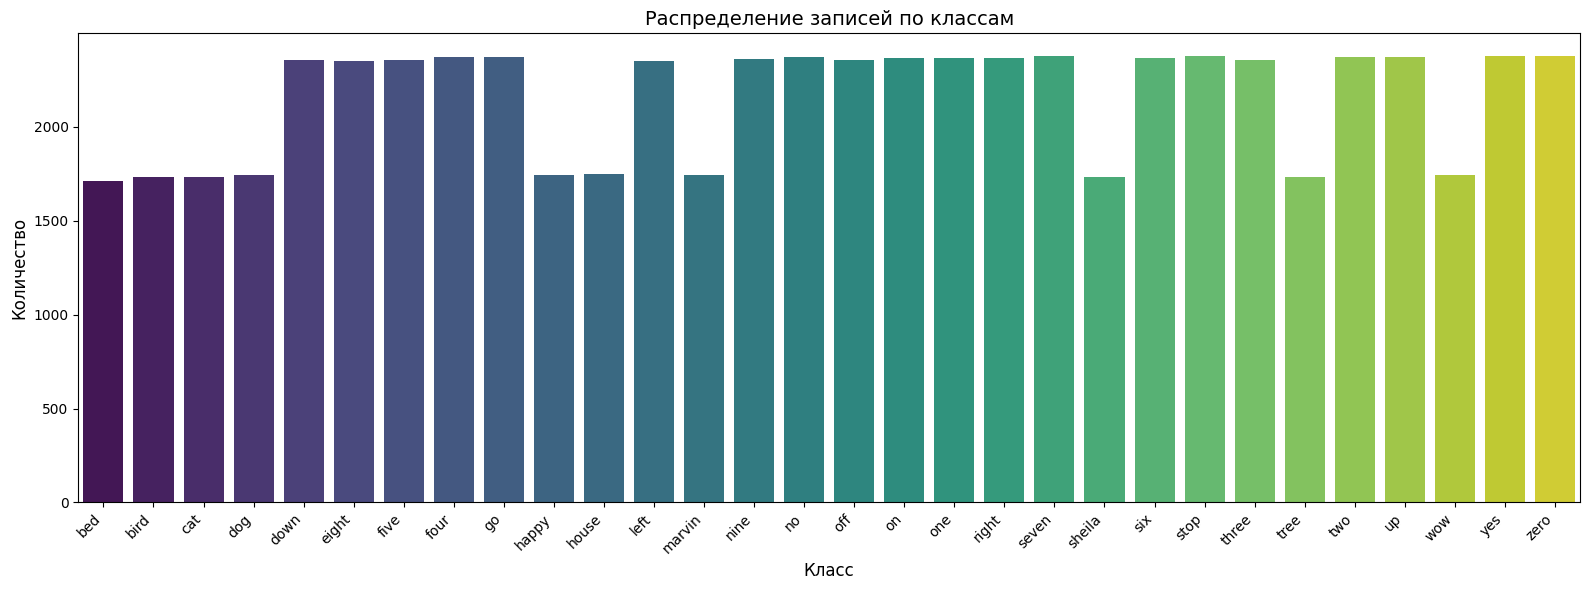

In [5]:
counts = []
for command in commands:
    command_dir = os.path.join(dataset_path, command)
    if os.path.isdir(command_dir):
        num_files = len([f for f in os.listdir(command_dir) if os.path.isfile(os.path.join(command_dir, f))])
        counts.append(num_files)

plt.figure(figsize=(16, 6))
ax = sns.barplot(x=list(commands), y=counts, palette="viridis", order=commands)
plt.title('Распределение записей по классам', fontsize=14)
plt.xlabel('Класс', fontsize=12)
plt.ylabel('Количество', fontsize=12)

ax.set_xticklabels(commands, rotation=45, ha="right", fontsize=10)
plt.tight_layout()
plt.savefig('commands_count.png', dpi=300)
plt.show()

In [6]:
def create_stratified_split(source_dir, target_dir, test_val_ratio=0.2, random_seed=42):
    os.makedirs(os.path.join(target_dir, 'train'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'val'), exist_ok=True)
    os.makedirs(os.path.join(target_dir, 'test'), exist_ok=True)
    
    for class_name in os.listdir(source_dir):
        class_dir = os.path.join(source_dir, class_name)
        if not os.path.isdir(class_dir) or class_name == '_background_noise_':
            continue
            
        all_files = [f for f in os.listdir(class_dir) if f.endswith('.wav')]
        if not all_files:
            continue
            
        train_files, temp_files = train_test_split(
            all_files,
            test_size=test_val_ratio,
            random_state=random_seed
        )
        val_files, test_files = train_test_split(
            temp_files,
            test_size=0.5,
            random_state=random_seed
        )
        
        for folder in ['train', 'val', 'test']:
            os.makedirs(os.path.join(target_dir, folder, class_name), exist_ok=True)
        
        def copy_files(files, target_folder):
            for f in files:
                src = os.path.join(class_dir, f)
                dst = os.path.join(target_dir, target_folder, class_name, f)
                shutil.copy2(src, dst)
        
        copy_files(train_files, 'train')
        copy_files(val_files, 'val')
        copy_files(test_files, 'test')
        
        print(f'Class {class_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test')

In [7]:
SOURCE_DIR = '/kaggle/working/train/train/audio'
TARGET_DIR = '/kaggle/working/split_data'
    
create_stratified_split(SOURCE_DIR, TARGET_DIR)
    
total_train = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'train')))
total_val = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'val')))
total_test = sum(len(files) for _, _, files in os.walk(os.path.join(TARGET_DIR, 'test')))
    
print('\nИтоговые размеры:')
print(f'Train: {total_train} файлов')
print(f'Val: {total_val} файлов')
print(f'Test: {total_test} файлов')

Class left: 1882 train, 235 val, 236 test
Class on: 1893 train, 237 val, 237 test
Class no: 1900 train, 237 val, 238 test
Class zero: 1900 train, 238 val, 238 test
Class happy: 1393 train, 174 val, 175 test
Class house: 1400 train, 175 val, 175 test
Class two: 1898 train, 237 val, 238 test
Class right: 1893 train, 237 val, 237 test
Class bird: 1384 train, 173 val, 174 test
Class eight: 1881 train, 235 val, 236 test
Class seven: 1901 train, 238 val, 238 test
Class one: 1896 train, 237 val, 237 test
Class yes: 1901 train, 238 val, 238 test
Class up: 1900 train, 237 val, 238 test
Class marvin: 1396 train, 175 val, 175 test
Class tree: 1386 train, 173 val, 174 test
Class three: 1884 train, 236 val, 236 test
Class dog: 1396 train, 175 val, 175 test
Class down: 1887 train, 236 val, 236 test
Class four: 1897 train, 237 val, 238 test
Class bed: 1370 train, 171 val, 172 test
Class five: 1885 train, 236 val, 236 test
Class six: 1895 train, 237 val, 237 test
Class stop: 1904 train, 238 val, 238 t

In [8]:
def add_random_noise(waveform, max_noise_level=0.02):
    noise_level = tf.random.uniform(shape=[], maxval=max_noise_level)
    noise = tf.random.normal(shape=tf.shape(waveform), mean=0.0, stddev=noise_level)
    return waveform + noise

In [9]:
def random_volume(waveform, min_factor=0.5, max_factor=1.5):
    factor = tf.random.uniform(shape=[], minval=min_factor, maxval=max_factor)
    return waveform * factor

In [10]:
def time_shift(waveform, shift_max=0.2):
    shift = int(tf.random.uniform([], -shift_max, shift_max) * SAMPLE_RATE)
    return tf.roll(waveform, shift, axis=0)

In [11]:
def stretch_time(waveform, min_rate=0.8, max_rate=1.25):
    rate = tf.random.uniform([], minval=min_rate, maxval=max_rate)

    def _np_stretch(wav_np, rate_np):
        import numpy as np
        orig_len = wav_np.shape[0]
        
        target_len = int(orig_len * float(rate_np))
        if target_len < 2:
            return wav_np
            
        x_old = np.linspace(0, orig_len - 1, orig_len)
        x_new = np.linspace(0, orig_len - 1, target_len)
        
        stretched = np.interp(x_new, x_old, wav_np).astype(np.float32)
        
        if stretched.shape[0] < orig_len:
            pad = np.zeros(orig_len - stretched.shape[0], dtype=np.float32)
            stretched = np.concatenate([stretched, pad])
        else:
            stretched = stretched[:orig_len]
        return stretched

    stretched = tf.numpy_function(_np_stretch, [waveform, rate], tf.float32)
    stretched.set_shape(waveform.shape)
    return stretched

In [12]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)

In [13]:
def add_augmented_files(dataset_dir):
    for class_name in tqdm(os.listdir(dataset_dir), desc='Processing classes'):
        class_dir = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_dir) or class_name == '_background_noise_':
            continue

        existing_files = set(os.listdir(class_dir))

        for filename in os.listdir(class_dir):
            if filename.startswith('aug_'):
                continue

            input_path = os.path.join(class_dir, filename)
            aug_filename = f'aug_{filename}'

            if aug_filename not in existing_files:
                audio_binary = tf.io.read_file(input_path)
                waveform = decode_audio(audio_binary)

                augmented = add_random_noise(
                    random_volume(
                        time_shift(
                            stretch_time(waveform)
                        )
                    )
                )

                aug_path = os.path.join(class_dir, aug_filename)
                wav_data = tf.audio.encode_wav(augmented[:, tf.newaxis], SAMPLE_RATE)
                tf.io.write_file(aug_path, wav_data)


dataset_path = '/kaggle/working/split_data/train'

add_augmented_files(dataset_path)

Processing classes:   0%|          | 0/30 [00:00<?, ?it/s]I0000 00:00:1748084508.378922      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1748084508.379613      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
Processing classes: 100%|██████████| 30/30 [04:40<00:00,  9.35s/it]


In [14]:
def load_split_dataset(base_dir):
    base = pathlib.Path(base_dir)

    train_files = [str(p) for p in base.joinpath('train').rglob('*.wav')]
    val_files   = [str(p) for p in base.joinpath('val').rglob('*.wav')]
    test_files  = [str(p) for p in base.joinpath('test').rglob('*.wav')]

    return train_files, val_files, test_files

In [15]:
TARGET_DIR = '/kaggle/working/split_data'
train_files, val_files, test_files = load_split_dataset(TARGET_DIR)

print(f'Train files: {len(list(train_files))}')
print(f'Val files: {len(list(val_files))}')
print(f'Test files: {len(list(test_files))}')

Train files: 103528
Val files: 6471
Test files: 6486


In [16]:
def get_label(file_path):
  parts = tf.strings.split(input=file_path,sep=os.path.sep)
  return parts[-2]

In [17]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

# SpectDataset

In [18]:
def get_spectrogram(waveform):
    input_len = 16000
    waveform = waveform[:input_len]
    
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    waveform = tf.cast(waveform, dtype=tf.float32)
    
    equal_length = tf.concat([waveform, zero_padding], 0)

    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [19]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [20]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    return (
        files_ds
        .map(get_waveform_and_label,      num_parallel_calls=tf.data.AUTOTUNE)
        .map(get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
    )

In [21]:
spectrogram_ds = preprocess_dataset(train_files)
test_ds = preprocess_dataset(test_files)

In [22]:
batch_size = 128

train_ds = (
    preprocess_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    preprocess_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Размер входа', input_shape)

num_labels = len(commands)

Размер входа (124, 129, 1)


# Dense

In [24]:
model_spect_dense = models.Sequential([
    layers.Input(shape=(input_shape[0] * input_shape[1],)),

    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels)
])

model_spect_dense.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 1024)                │      16,380,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,080,990 (65.16 MB)

 Trainable params: 17,077,406 (65.15 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [25]:
model_spect_dense.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [26]:
train_ds_dense = train_ds.map(lambda x, y: (tf.reshape(x, [-1, input_shape[0] * input_shape[1]]), y))
val_ds_dense = val_ds.map(lambda x, y: (tf.reshape(x, [-1, input_shape[0] * input_shape[1]]), y))
test_ds_dense = test_ds.map(lambda x, y: (tf.reshape(x, [-1, input_shape[0] * input_shape[1]]), y))

In [27]:
EPOCHS = 50

history = model_spect_dense.fit(
    train_ds_dense,
    validation_data=val_ds_dense,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
)

Epoch 1/50


I0000 00:00:1748077783.634517     110 service.cc:148] XLA service 0x7825880157b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748077783.635365     110 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1748077783.635391     110 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1748077784.058848     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


 15/809 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.0388 - loss: 3.9312  

I0000 00:00:1748077787.136343     110 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


809/809 ━━━━━━━━━━━━━━━━━━━━ 65s 17ms/step - accuracy: 0.1744 - loss: 2.9318 - val_accuracy: 0.5786 - val_loss: 1.4078
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.4231 - loss: 1.9076 - val_accuracy: 0.6959 - val_loss: 1.0757
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5081 - loss: 1.6154 - val_accuracy: 0.7226 - val_loss: 0.9624
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5566 - loss: 1.4528 - val_accuracy: 0.7552 - val_loss: 0.8653
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.5904 - loss: 1.3385 - val_accuracy: 0.7801 - val_loss: 0.7873
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6150 - loss: 1.2488 - val_accuracy: 0.7796 - val_loss: 0.7591
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6367 - loss: 1.1820 - val_accuracy: 0.7911 - val_loss: 0.7317
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.6498 - loss: 1.1330 - val_accuracy: 0.8040 - va

In [28]:
model_spect_dense.save("spect_dense.keras")

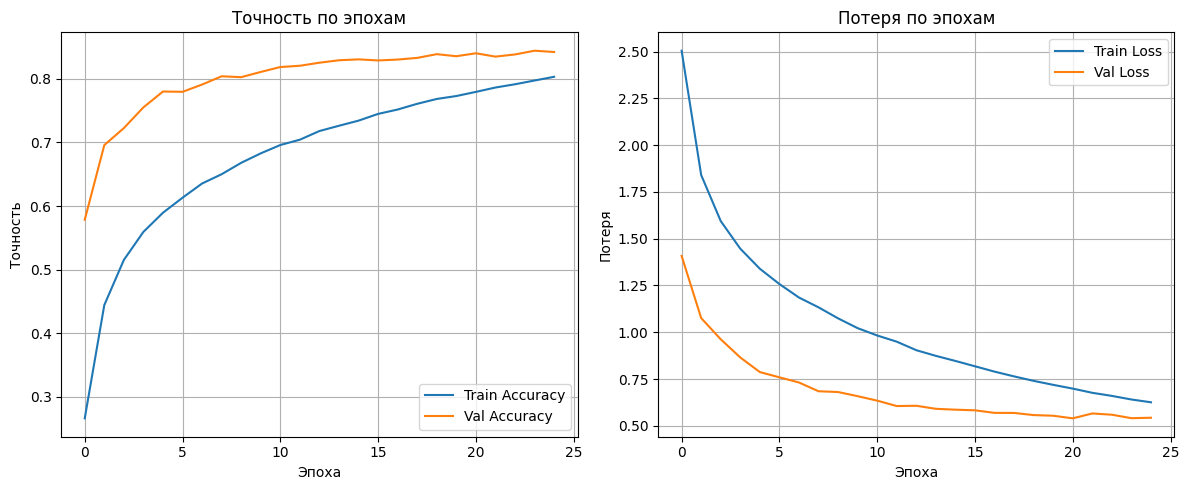

In [29]:
metrics = history.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_spect_dense.png", dpi=300)
plt.show()

In [30]:
test_audio = []
test_labels = []

for audio, label in test_ds_dense:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

test_audio = np.squeeze(test_audio, axis=1)

In [31]:
y_pred = np.argmax(model_spect_dense.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Точность на тестовом наборе: 84%


In [32]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.7435    0.8256    0.7824       172
        bird     0.8807    0.8908    0.8857       174
         cat     0.7579    0.8276    0.7912       174
         dog     0.7219    0.7714    0.7459       175
        down     0.7991    0.7585    0.7783       236
       eight     0.8750    0.8898    0.8824       236
        five     0.7244    0.7797    0.7510       236
        four     0.9008    0.9160    0.9083       238
          go     0.6951    0.7185    0.7066       238
       happy     0.9130    0.9600    0.9359       175
       house     0.9306    0.9200    0.9253       175
        left     0.8667    0.8263    0.8460       236
      marvin     0.8793    0.8743    0.8768       175
        nine     0.8802    0.8059    0.8414       237
          no     0.7833    0.7899    0.7866       238
         off     0.7968    0.8475    0.8214       236
          on     0.8680    0.7215    0.7880       237
         one     0.8813    

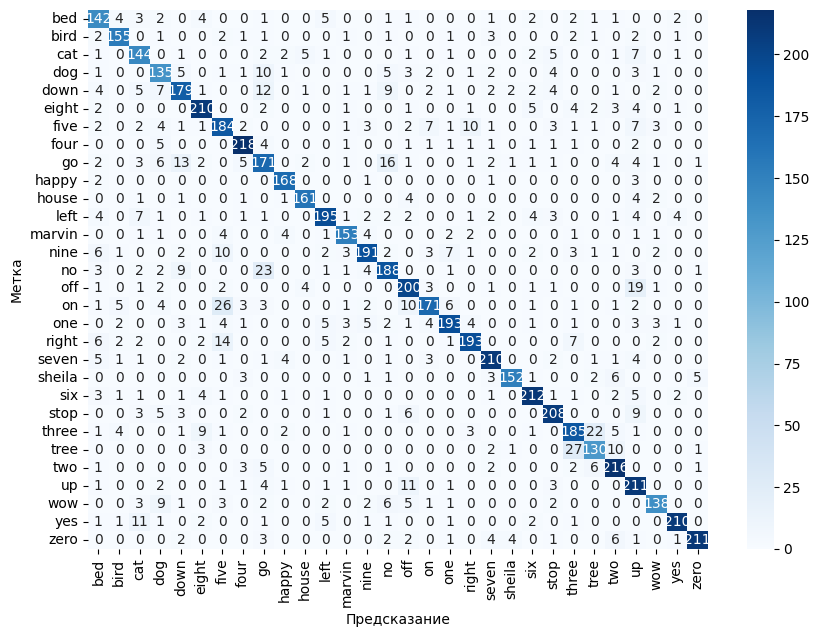

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_spect_dense.png", dpi=300)
plt.show()

# CNNLight

In [34]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

In [35]:
model_spect_cnn_light = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    
    layers.Conv2D(32, kernel_size=(3,3), padding='same'),
    layers.Activation('relu'),
    
    layers.Conv2D(64, kernel_size=(5,5), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(128, kernel_size=(7,7), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(256, kernel_size=(9,9), padding='same'),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    
    layers.Dense(num_labels),
])

model_spect_cnn_light.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 32, 32, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 8, 8, 256)           │       2,654,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │         524,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 30)                  │           3,870 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,635,873 (13.87 MB)

 Trainable params: 3,635,870 (13.87 MB)

 Non-trainable params: 3 (16.00 B)

In [36]:
model_spect_cnn_light.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [37]:
EPOCHS = 50
history = model_spect_cnn_light.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
)

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 51s 49ms/step - accuracy: 0.2481 - loss: 2.6147 - val_accuracy: 0.8524 - val_loss: 0.5113
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.7206 - loss: 0.9691 - val_accuracy: 0.8926 - val_loss: 0.3702
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.7868 - loss: 0.7458 - val_accuracy: 0.9099 - val_loss: 0.3122
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8165 - loss: 0.6489 - val_accuracy: 0.9138 - val_loss: 0.3047
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8321 - loss: 0.5898 - val_accuracy: 0.9249 - val_loss: 0.2672
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8437 - loss: 0.5395 - val_accuracy: 0.9277 - val_loss: 0.2501
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8498 - loss: 0.5151 - val_accuracy: 0.9260 - val_loss: 0.2694
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - accuracy: 0.8586 - loss: 0.4930 - 

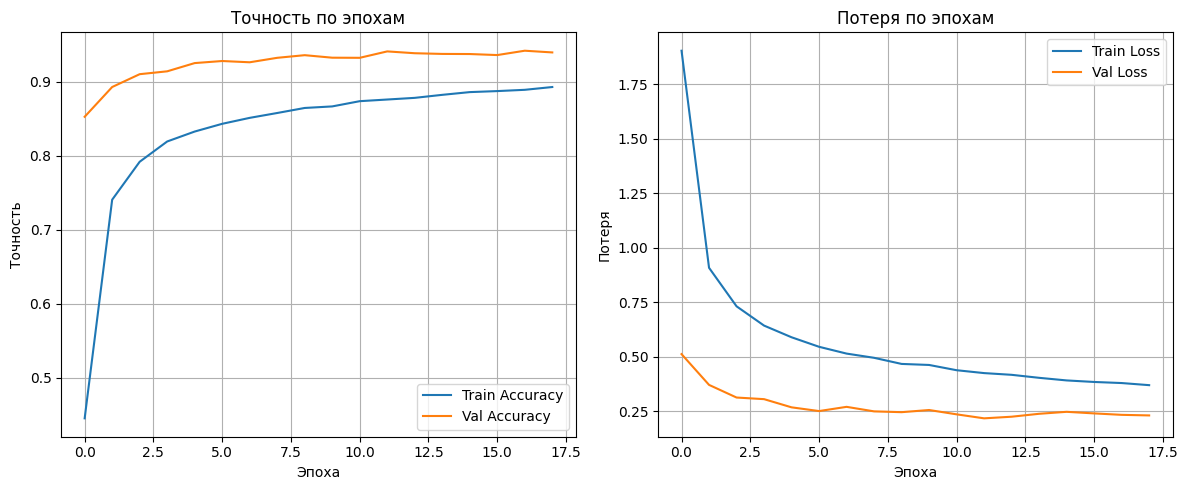

In [38]:
metrics = history.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_spect_cnn_light.png", dpi=300)
plt.show()

In [39]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [40]:
y_pred = np.argmax(model_spect_cnn_light.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Точность на тестовом наборе: 94%


In [41]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9157    0.9477    0.9314       172
        bird     0.9483    0.9483    0.9483       174
         cat     0.9126    0.9598    0.9356       174
         dog     0.9641    0.9200    0.9415       175
        down     0.9145    0.9068    0.9106       236
       eight     0.9500    0.9661    0.9580       236
        five     0.9069    0.9492    0.9275       236
        four     0.9662    0.9622    0.9642       238
          go     0.9027    0.8571    0.8793       238
       happy     0.9886    0.9886    0.9886       175
       house     0.9657    0.9657    0.9657       175
        left     0.9694    0.9407    0.9548       236
      marvin     0.9713    0.9657    0.9685       175
        nine     0.9646    0.9198    0.9417       237
          no     0.9024    0.9328    0.9174       238
         off     0.9614    0.9492    0.9552       236
          on     0.9565    0.9283    0.9422       237
         one     0.9515    

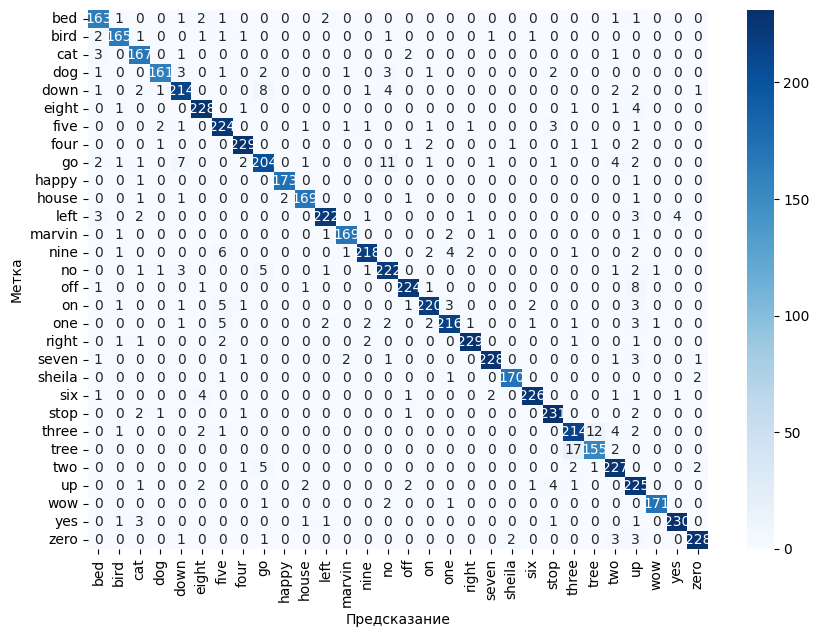

In [42]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_spect_cnn_light.png", dpi=300)
plt.show()

In [43]:
model_spect_cnn_light.save("spect_cnn_light.keras")

# CNN

In [44]:
norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

In [45]:
model_spect_cnn = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,

    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(256, kernel_size=7, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(512, kernel_size=9, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_labels)
])

model_spect_cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_1 (Normalization)      │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 16, 16, 256)         │       1,605,888 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 14,557,089 (55.53 MB)

 Trainable params: 14,554,590 (55.52 MB)

 Non-trainable params: 2,499 (9.77 KB)

In [46]:
model_spect_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [47]:
EPOCHS = 50
history = model_spect_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True),
)

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 154s 162ms/step - accuracy: 0.2245 - loss: 2.9522 - val_accuracy: 0.8476 - val_loss: 0.5265
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 110s 136ms/step - accuracy: 0.8016 - loss: 0.6789 - val_accuracy: 0.9070 - val_loss: 0.3442
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 110s 136ms/step - accuracy: 0.8656 - loss: 0.4564 - val_accuracy: 0.9311 - val_loss: 0.2401
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 110s 135ms/step - accuracy: 0.8916 - loss: 0.3724 - val_accuracy: 0.9348 - val_loss: 0.2260
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 109s 135ms/step - accuracy: 0.9023 - loss: 0.3269 - val_accuracy: 0.9284 - val_loss: 0.2495
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 109s 135ms/step - accuracy: 0.9137 - loss: 0.2941 - val_accuracy: 0.9442 - val_loss: 0.1969
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 109s 135ms/step - accuracy: 0.9213 - loss: 0.2667 - val_accuracy: 0.9417 - val_loss: 0.2058
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 109s 135ms/step - accuracy: 0.9260 -

In [48]:
model_spect_cnn.save("spect_cnn.keras")

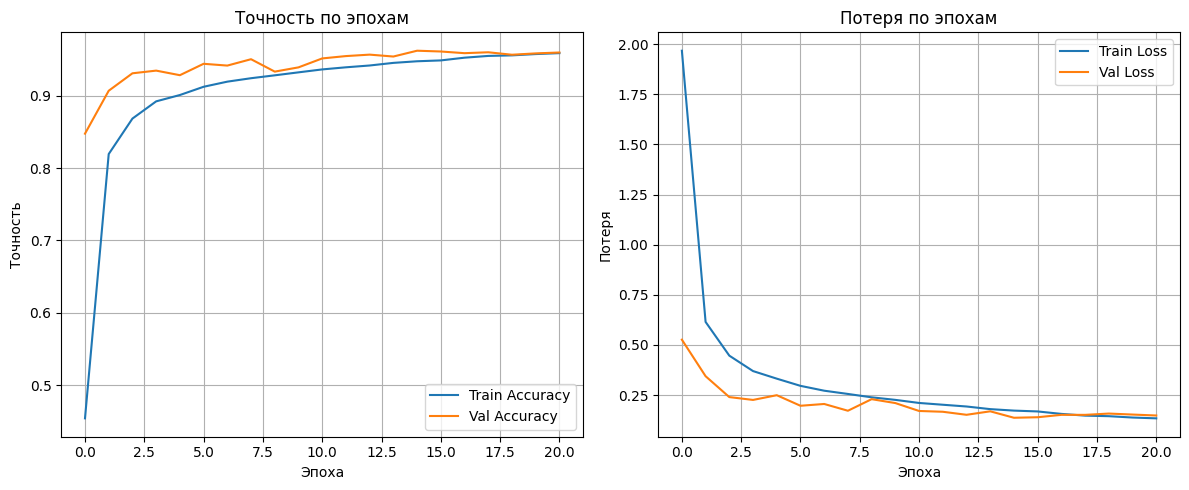

In [49]:
metrics = history.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.epoch, metrics['loss'], label='Train Loss')
plt.plot(history.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_spect_cnn.png", dpi=300)
plt.show()

In [50]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [51]:
y_pred = np.argmax(model_spect_cnn.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
Точность на тестовом наборе: 97%


In [52]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9333    0.9767    0.9545       172
        bird     0.9880    0.9425    0.9647       174
         cat     0.9661    0.9828    0.9744       174
         dog     0.9827    0.9714    0.9770       175
        down     0.9868    0.9492    0.9676       236
       eight     0.9742    0.9619    0.9680       236
        five     0.9787    0.9746    0.9766       236
        four     0.9831    0.9790    0.9811       238
          go     0.8321    0.9790    0.8996       238
       happy     1.0000    0.9943    0.9971       175
       house     0.9943    0.9886    0.9914       175
        left     0.9619    0.9619    0.9619       236
      marvin     0.9942    0.9829    0.9885       175
        nine     0.9791    0.9873    0.9832       237
          no     0.9551    0.9832    0.9689       238
         off     0.9528    0.9407    0.9467       236
          on     0.9744    0.9620    0.9682       237
         one     0.9870    

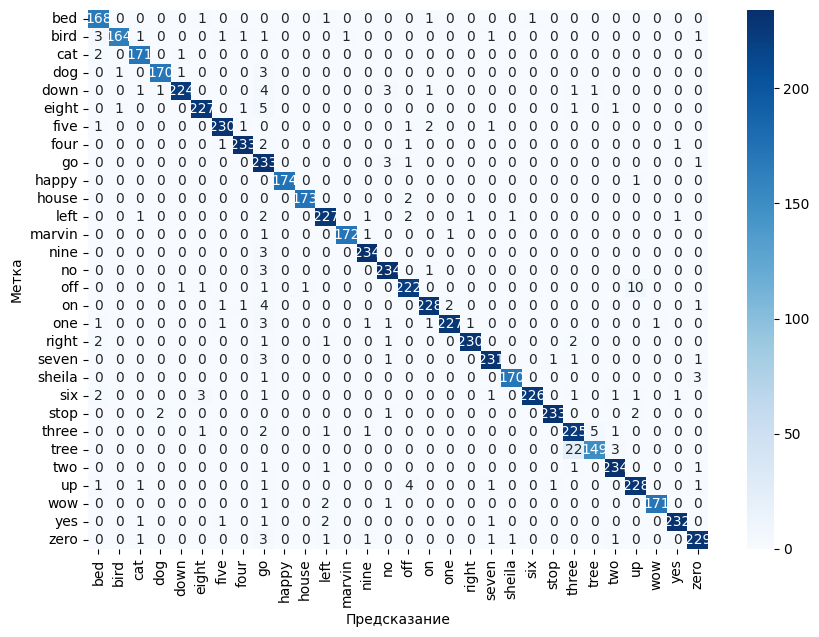

In [53]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_spect_cnn.png", dpi=300)
plt.show()

# TCN

In [54]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.squeeze(spectrogram, axis=-1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [55]:
spectrogram_ds = preprocess_dataset(train_files)
test_ds = preprocess_dataset(test_files)

In [56]:
batch_size = 128

train_ds = (
    preprocess_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    preprocess_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [57]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Новый размер входа:', input_shape)

Новый размер входа: (124, 129)


In [58]:
norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, y: x))

In [59]:
model_spect_tcn = models.Sequential([
    layers.Input(shape=input_shape),
    norm_layer,
    
    layers.Conv1D(64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(64, kernel_size=3, dilation_rate=1, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(128, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(128, kernel_size=3, dilation_rate=2, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.MaxPooling1D(pool_size=2),
    
    layers.Conv1D(256, kernel_size=3, dilation_rate=4, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Conv1D(256, kernel_size=3, dilation_rate=4, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.Conv1D(256, kernel_size=3, dilation_rate=8, padding='causal', activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    
    layers.GlobalAveragePooling1D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels)
])

model_spect_tcn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization_2 (Normalization)      │ (None, 124, 129)            │             259 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 124, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 124, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 124, 64)             │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 124, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 124, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 62, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 62, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 62, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 62, 128)             │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 62, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 62, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 31, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 31, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 31, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 31, 256)             │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 31, 256)             │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 31, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 681,825 (2.60 MB)

 Trainable params: 679,262 (2.59 MB)

 Non-trainable params: 2,563 (10.02 KB)

In [60]:
model_spect_tcn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [61]:
EPOCHS = 50
history_tcn = model_spect_tcn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
)

Epoch 1/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 90s 35ms/step - accuracy: 0.3505 - loss: 2.2598 - val_accuracy: 0.8569 - val_loss: 0.4870
Epoch 2/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7877 - loss: 0.7227 - val_accuracy: 0.8385 - val_loss: 0.5728
Epoch 3/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8377 - loss: 0.5565 - val_accuracy: 0.9091 - val_loss: 0.3176
Epoch 4/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8615 - loss: 0.4730 - val_accuracy: 0.9017 - val_loss: 0.3565
Epoch 5/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8744 - loss: 0.4278 - val_accuracy: 0.9277 - val_loss: 0.2491
Epoch 6/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8849 - loss: 0.3962 - val_accuracy: 0.9189 - val_loss: 0.3073
Epoch 7/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8895 - loss: 0.3750 - val_accuracy: 0.9342 - val_loss: 0.2358
Epoch 8/50
809/809 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.8953 - loss: 0.3499 - 

In [62]:
model_spect_tcn.save("spect_tcn.keras")

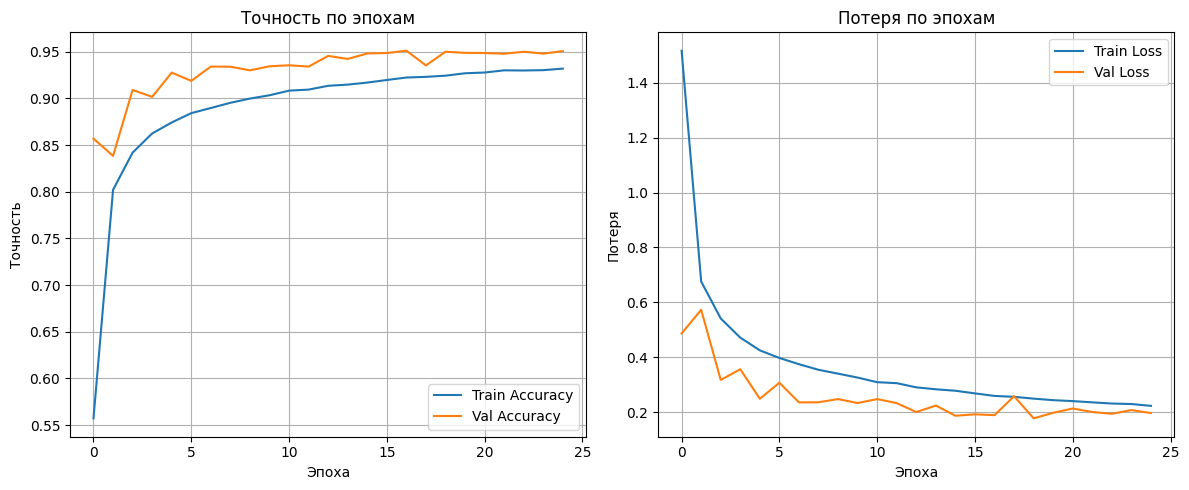

In [63]:
metrics = history_tcn.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_tcn.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history_tcn.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_tcn.epoch, metrics['loss'], label='Train Loss')
plt.plot(history_tcn.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_spect_tcn.png", dpi=300)
plt.show()

In [64]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [65]:
y_pred = np.argmax(model_spect_tcn.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Точность на тестовом наборе: 96%


In [66]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.8594    0.9593    0.9066       172
        bird     0.9588    0.9368    0.9477       174
         cat     0.9879    0.9368    0.9617       174
         dog     0.9337    0.9657    0.9494       175
        down     0.9567    0.9364    0.9465       236
       eight     0.9496    0.9576    0.9536       236
        five     0.9698    0.9534    0.9615       236
        four     0.9957    0.9706    0.9830       238
          go     0.9383    0.9580    0.9480       238
       happy     0.9774    0.9886    0.9830       175
       house     0.9827    0.9714    0.9770       175
        left     0.9821    0.9280    0.9542       236
      marvin     0.9828    0.9771    0.9799       175
        nine     0.9315    0.9747    0.9526       237
          no     0.9469    0.9748    0.9607       238
         off     0.9596    0.9068    0.9325       236
          on     0.9540    0.9620    0.9580       237
         one     0.9782    

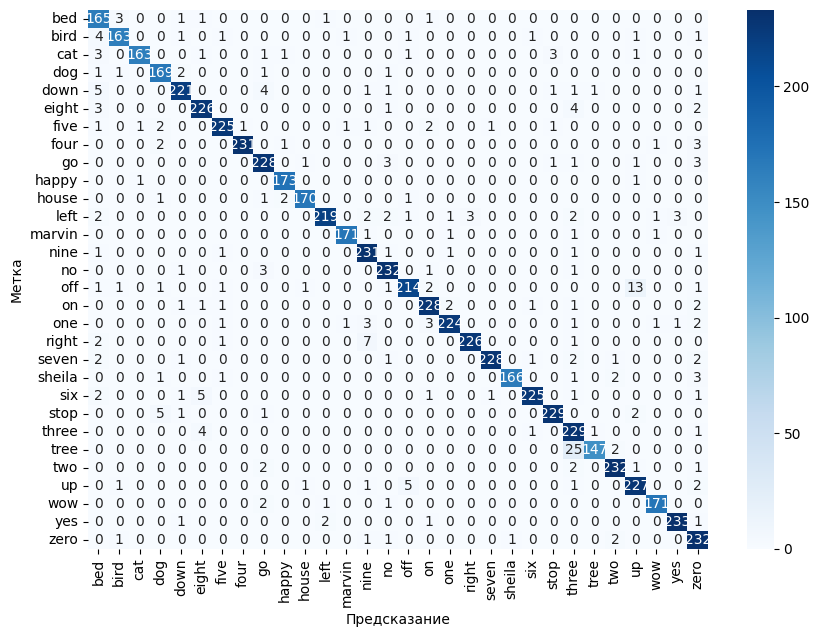

In [67]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_spect_tcn.png", dpi=300)
plt.show()

# CRNN

In [24]:
def get_spectrogram_and_label_id(audio, label):
    spectrogram = get_spectrogram(audio)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

In [25]:
spectrogram_ds = preprocess_dataset(train_files)
test_ds = preprocess_dataset(test_files)

In [26]:
batch_size = 32

train_ds = (
    preprocess_dataset(train_files)
    .cache()
    .shuffle(buffer_size=len(train_files), seed=42)
    .batch(batch_size)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    preprocess_dataset(val_files)
    .batch(batch_size)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)

In [27]:
for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape
print('Новый размер входа:', input_shape)

Новый размер входа: (124, 129, 1)


In [28]:
norm_layer = layers.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, y: x))

In [29]:
model_spect_crnn = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(64, 64),
    norm_layer,

    layers.Conv2D(32, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),

    layers.Conv2D(64, kernel_size=3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.3),

    layers.Conv2D(128, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(256, kernel_size=5, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    layers.Conv2D(512, kernel_size=7, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.4),

    # Предполагается, что после последнего слоя размерность равна (4, 4, 512)
    # Преобразуем в последовательность длиной 16 (4*4) с 512 признаками на шаг
    layers.Reshape((16, 512)),

    # Рекуррентные слои для моделирования последовательной зависимости
    layers.Bidirectional(layers.LSTM(128, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(128)),

    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(num_labels)
])


model_spect_crnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization (Normalization)        │ (None, 64, 64, 1)           │               3 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 64, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64, 64, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 64, 64, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 32, 32, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 32, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 256)         │         819,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 8,595,361 (32.79 MB)

 Trainable params: 8,592,862 (32.78 MB)

 Non-trainable params: 2,499 (9.77 KB)

In [30]:
model_spect_crnn.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [31]:
EPOCHS = 150
history_crnn = model_spect_crnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
)

Epoch 1/150


E0000 00:00:1748085147.414503      31 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1748085196.210751     110 cuda_dnn.cc:529] Loaded cuDNN version 90300


3236/3236 ━━━━━━━━━━━━━━━━━━━━ 279s 67ms/step - accuracy: 0.3244 - loss: 2.4226 - val_accuracy: 0.8061 - val_loss: 0.6576
Epoch 2/150
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 214s 66ms/step - accuracy: 0.8080 - loss: 0.6526 - val_accuracy: 0.9023 - val_loss: 0.3281
Epoch 3/150
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 214s 66ms/step - accuracy: 0.8612 - loss: 0.4813 - val_accuracy: 0.9315 - val_loss: 0.2397
Epoch 4/150
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 213s 66ms/step - accuracy: 0.8842 - loss: 0.4016 - val_accuracy: 0.9478 - val_loss: 0.1813
Epoch 5/150
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 213s 66ms/step - accuracy: 0.8974 - loss: 0.3549 - val_accuracy: 0.9407 - val_loss: 0.1967
Epoch 6/150
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 214s 66ms/step - accuracy: 0.9060 - loss: 0.3247 - val_accuracy: 0.9403 - val_loss: 0.2114
Epoch 7/150
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 214s 66ms/step - accuracy: 0.9158 - loss: 0.2906 - val_accuracy: 0.9567 - val_loss: 0.1479
Epoch 8/150
3236/3236 ━━━━━━━━━━━━━━━━━━━━ 214s 66ms/step - accuracy: 0.91

In [32]:
model_spect_crnn.save("spect_crnn.keras")

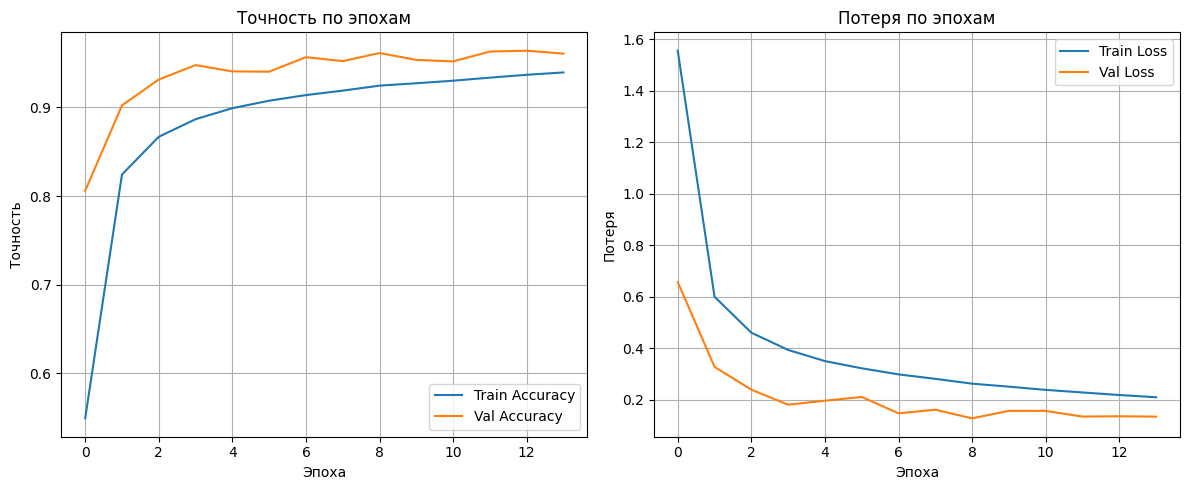

In [33]:
metrics = history_crnn.history

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_crnn.epoch, metrics['accuracy'], label='Train Accuracy')
plt.plot(history_crnn.epoch, metrics['val_accuracy'], label='Val Accuracy')
plt.title('Точность по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history_crnn.epoch, metrics['loss'], label='Train Loss')
plt.plot(history_crnn.epoch, metrics['val_loss'], label='Val Loss')
plt.title('Потеря по эпохам')
plt.xlabel('Эпоха')
plt.ylabel('Потеря')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig("training_metrics_spect_crnn.png", dpi=300)
plt.show()

In [34]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [35]:
y_pred = np.argmax(model_spect_crnn.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Точность на тестовом наборе: {test_acc:.0%}')

203/203 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step
Точность на тестовом наборе: 96%


In [36]:
report = classification_report(y_true, y_pred, target_names=commands, digits=4)
print(report)

              precision    recall  f1-score   support

         bed     0.9765    0.9651    0.9708       172
        bird     0.9882    0.9598    0.9738       174
         cat     0.9655    0.9655    0.9655       174
         dog     0.9714    0.9714    0.9714       175
        down     0.9697    0.9492    0.9593       236
       eight     0.9831    0.9831    0.9831       236
        five     0.9737    0.9407    0.9569       236
        four     0.9956    0.9412    0.9676       238
          go     0.8964    0.9454    0.9202       238
       happy     0.9886    0.9886    0.9886       175
       house     0.9774    0.9886    0.9830       175
        left     0.9733    0.9280    0.9501       236
      marvin     1.0000    0.9829    0.9914       175
        nine     0.9828    0.9620    0.9723       237
          no     0.9914    0.9706    0.9809       238
         off     0.9524    0.9322    0.9422       236
          on     0.9402    0.9283    0.9342       237
         one     0.9661    

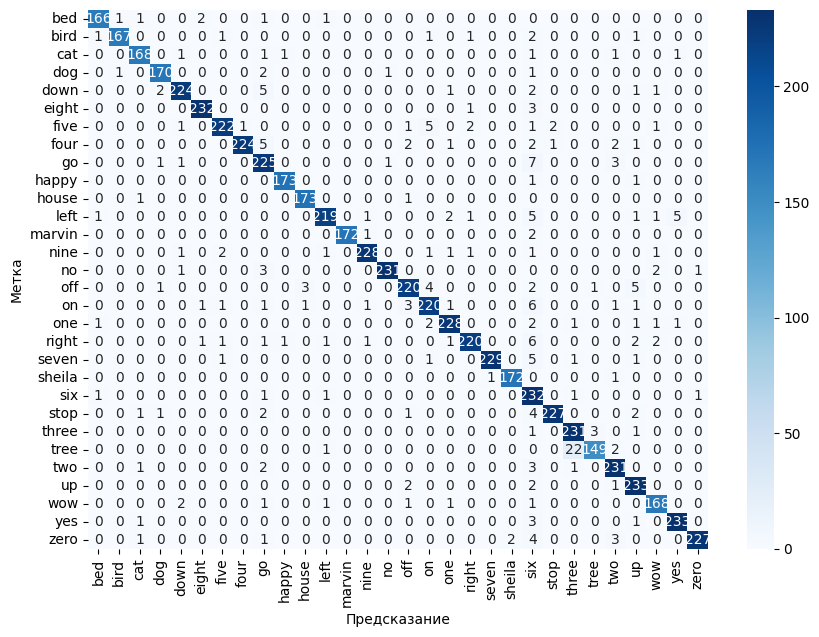

In [37]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))

sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g',
            cmap='Blues')
plt.xlabel('Предсказание')
plt.ylabel('Метка')
plt.savefig("conf_matrix_spect_crnn.png", dpi=300)
plt.show()